In [79]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [80]:
# Clean the data
df = pd.read_csv('housing.csv')
df = df[~df['PropType'].isna()]
df = df[~df['Style'].isna()]
df = df[~(df['Units'] >= 4)]
df = df[~(df['Bdrms'] >= 15)]
df['Year'] = df['Sale_date'].str[:4].astype(int)
df['Month'] = df['Sale_date'].str[-2:].astype(int)
df = df.drop(columns = ['CondoProject', 'Extwall','Taxkey','Address','Nbhd','Style', 'Sale_date']) # Maybe include: Nbhd, Style
# display(df.columns)
# name = df.columns[1]
# counts = df[name].value_counts()
# display(counts)
# display(len(counts))
# display(type(df[name].values[0]))
# display(max(counts.keys()))

# Take a One-Hot of the following: District, PropType, Month
df = pd.get_dummies(df, columns = ['District', 'PropType', 'Month'])
X = df.drop(columns = ['Sale_price'])
y = df['Sale_price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Run a random forest classifier
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print('MAE:', mae)

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

MAE: 79962.76456812273


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [81]:
print('MAE:', mae)

MAE: 79962.76456812273


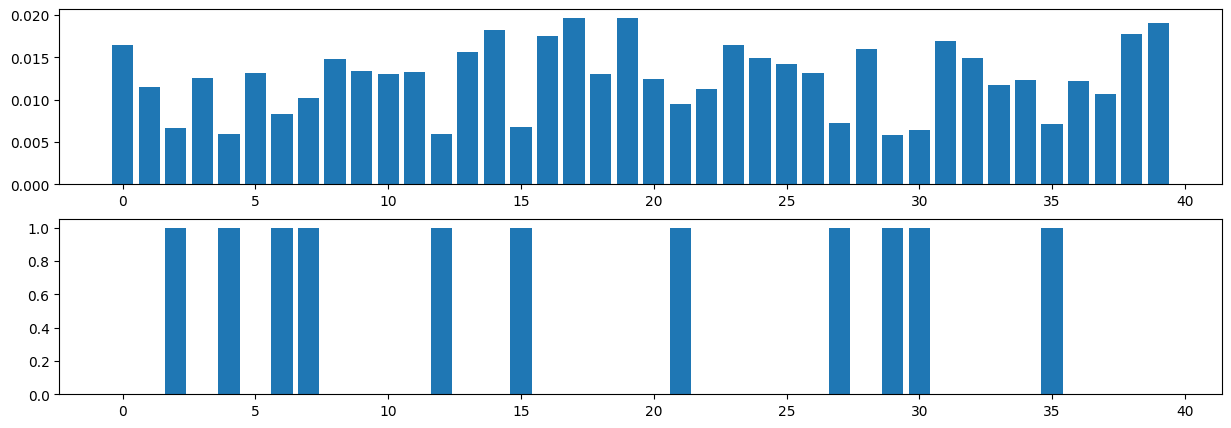

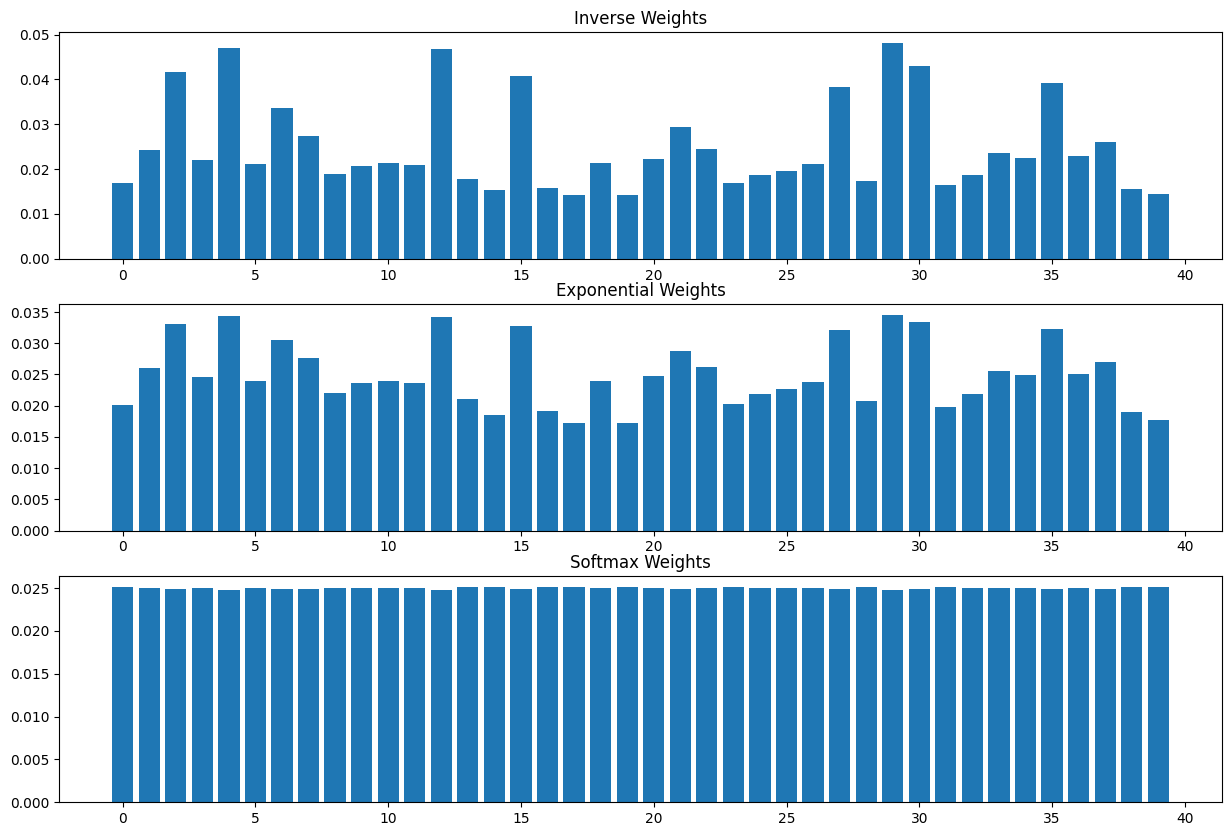

In [82]:
### IDEA:
# Divide the rows by the number of non zero entries in it (this essentially accounts for trees with different leaf sizes)
# Simple two norm method
# Square the norm maybe?

# Simple two norm method
# generate a 20 by 8 matrix of random numbers between 5 and 15
np.random.seed(42)
leaf_size = 8
n_trees = 40
train_leaf_counts = np.random.randint(50, 70, (n_trees, leaf_size))
train_weights = train_leaf_counts / np.sum(train_leaf_counts, axis=1)[:,np.newaxis]
train_weights

# do the same for Y, test weights
variation = np.random.randint(0, 5, (n_trees, leaf_size))
bias_trees = np.random.randint(-1, 1, n_trees)
bias_nuance = np.random.randint(-1, 1, (n_trees, leaf_size))
bias = 5 * bias_trees[:,np.newaxis]*bias_nuance

test_leaf_counts = train_leaf_counts + variation + bias
test_weights = test_leaf_counts / np.sum(test_leaf_counts, axis=1)[:,np.newaxis]
test_weights


tree_differences = np.linalg.norm(train_weights - test_weights, axis=1)

# plot a bar chart of tree differences
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.bar(np.arange(n_trees), tree_differences)
plt.subplot(2, 1, 2)
plt.bar(np.arange(n_trees), 1 + bias_trees)


##### Converting to a weighted norm #####
# Method 1: Inverse Transformation
epsilon = 1e-6
inverse_weights = 1 / (tree_differences + epsilon)
inverse_weights_normalized = inverse_weights / np.sum(inverse_weights)
# Method 2: Exponential Decay Function
alpha = 50  # This can be tuned
exp_weights = np.exp(-alpha * tree_differences)
exp_weights_normalized = exp_weights / np.sum(exp_weights)

# Method 3: Softmax Function
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Stability improvement by subtracting max
    return e_x / e_x.sum(axis=0)

### IDEA:
# If the labels come at a lag and we learn how biased the dataset is, we can continually update the alpha in the exponential decay function
# This would allow us to adapt to the bias of the dataset over time

# plot bar charts of the three different weights
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.bar(np.arange(n_trees), inverse_weights_normalized)
plt.title('Inverse Weights')
plt.subplot(3, 1, 2)
plt.bar(np.arange(n_trees), exp_weights_normalized)
plt.title('Exponential Weights')
plt.subplot(3, 1, 3)
plt.bar(np.arange(n_trees), softmax(tree_differences))
plt.title('Softmax Weights')
plt.show()